In [10]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import ttest_ind, f_oneway

In [2]:
# link for fetching data using helsinki-openapi.nuuka.cloud API
list_properties_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List"
property_search_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search"
hourly_electricity_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty"

In [3]:
# Fetch all property data
response_properties = requests.get(list_properties_url)
properties_data = response_properties.json()
print(properties_data)

[{'locationName': '1000 Hakaniemen kauppahalli', 'propertyName': '1000 Hakaniemen kauppahalli', 'propertyCode': '091-011-9902-0101'}, {'locationName': '1001 Hietalahden kauppahalli', 'propertyName': '1001 Hietalahden kauppahalli', 'propertyCode': '091-004-9902-0008'}, {'locationName': '1002 Vanha kauppahalli', 'propertyName': '1002 Vanha kauppahalli', 'propertyCode': '091-003-9906-0101'}, {'locationName': '1037 Vuotalo', 'propertyName': '1037 Vuotalo', 'propertyCode': '091-054-0179-0003'}, {'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003'}, {'locationName': '1508 Monitoimitalo Puustelli', 'propertyName': '1508 Monitoimitalo Puustelli', 'propertyCode': '091-033-0232-0003, 091-033-0260-0001'}, {'locationName': '1509 Lpk Karvikka ja rppk Lemmikki', 'propertyName': '1509 Lpk Karvikka ja rppk Lemmikki', 'propertyCode': '091-038-0055-0010'}, {'locationName': 

In [4]:
# Extract relevant property information
property_locations = [property_info['locationName'] for property_info in properties_data]
print(property_locations)

['1000 Hakaniemen kauppahalli', '1001 Hietalahden kauppahalli', '1002 Vanha kauppahalli', '1037 Vuotalo', '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', '1508 Monitoimitalo Puustelli', '1509 Lpk Karvikka ja rppk Lemmikki', '1511 Pauligin huvila (disabled)', '1512 Malmin raitti 3', '1513 Psykiatrinen poliklinikka', '1515 Myllypuron peruskoulu/Lpk Neulanen/Neulapadont. 6', '1521 Harjun NT (disabled)', '1526 Annantalo', '1527 Koskelan NT', '1528 Apollon yhteiskoulu', '1540 Virastotalo, Dagmarinkatu 6 (disabled)', '1544 Lpk Linnunlaulu ja Lpk Arla', '1546 Koulutuskeskus', '1550 Fallkullan kartano/Kotieläintila', '1556 Harakan luontokeskus', '1561 Työterveyskeskus', '1575 Nuorisoasiainkeskus, Lpk Leppäsuo', '1580 Kruununmakasiini', '1591 Etelä-Haagan kirjasto, NT', '1597 Lpk Lauttasaaren Ankkalampi (disabloitu)', '1598 Jakomäen kirjasto', '1603 Korttelitalo Merirasti', '1608 Koskelan ala-aste /Lpk Herttua', '1610 Laakavuoren korttelitalo/a-a/Lpk', '1620 Tulli- ja pakkahuone, K 11

In [5]:
# Function to fetch additional property information
def fetch_additional_property_info(location_name):
    search_params = {
        "SearchString": location_name,
        "SearchFromRecord": "LocationName"
    }
    response_property_search = requests.get(property_search_url, params=search_params)
    property_info = response_property_search.json()
    return property_info

In [6]:
# Fetch additional information for each property
with ThreadPoolExecutor(max_workers=10) as executor:
    additional_info = list(executor.map(fetch_additional_property_info, property_locations))

# Create a DataFrame from the additional information
additional_df = pd.DataFrame(additional_info)

In [7]:
# Function to fetch daily electricity data for a property
def fetch_hourly_data_for_property(property_location):
    hourly_params = {
        "Record": "LocationName",
        "SearchString": property_location,
        "ReportingGroup": "Electricity",
        "StartTime": "2022-01-01",
        "EndTime": "2023-10-31"
    }

    response_hourly_electricity = requests.get(hourly_electricity_url, params=hourly_params)
    hourly_electricity_data = response_hourly_electricity.json()

    return hourly_electricity_data

In [9]:
with ThreadPoolExecutor(max_workers=10) as executor:
    hourly_electricity_data_all_properties = list(executor.map(fetch_hourly_data_for_property, property_locations))

In [11]:
# Convert the list of dictionaries to a DataFrame
all_properties_hourly_electricity_df = pd.DataFrame(hourly_electricity_data_all_properties)

# Display the DataFrame
print("\nDaily Electricity Data for All Properties:")
all_properties_hourly_electricity_df.head()


Daily Electricity Data for All Properties:


,0,1,2,3,4,5,6,7,8,9,...,87518,87519,87520,87521,87522,87523,87524,87525,87526,87527
0,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
1,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
2,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
3,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
4,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None


In [12]:
print(all_properties_hourly_electricity_df.iloc[0, 0])

{'timestamp': '2022-01-01T00:00:00', 'reportingGroup': 'Electricity', 'locationName': '1000 Hakaniemen kauppahalli', 'value': 0.04, 'unit': 'kWh'}


In [13]:
# Creating an empty list to store dictionaries 
data_list = []

# Iterate over DataFrame rows using apply
def process_row(row):
    try:
        if isinstance(row, str):
            cell_data = json.loads(row)
        elif isinstance(row, dict):
            cell_data = row
        else:
            raise ValueError(f"Unsupported data type: {type(row)}")

        extracted_data = {
            'timestamp': cell_data.get('timestamp'),
            'reportingGroup': cell_data.get('reportingGroup'),
            'locationName': cell_data.get('locationName'),
            'consumption': cell_data.get('value'),
            'unit': cell_data.get('unit')
        }
        data_list.append(extracted_data)
    except (json.JSONDecodeError, AttributeError, ValueError):
        pass

# Apply the processing function to each cell in the DataFrame
all_properties_hourly_electricity_df.applymap(process_row)

# Create a DataFrame from the list of dictionaries
energy_df = pd.DataFrame(data_list)
energy_df.head()

,timestamp,reportingGroup,locationName,consumption,unit
0,2022-01-01T00:00:00,Electricity,1000 Hakaniemen kauppahalli,0.04,kWh
1,2022-01-01T00:00:00,Electricity,1001 Hietalahden kauppahalli,25.83,kWh
2,2022-01-01T00:00:00,Electricity,1002 Vanha kauppahalli,18.86,kWh
3,2022-01-01T00:00:00,Electricity,1037 Vuotalo,99.01,kWh
4,2022-01-01T00:00:00,Electricity,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,65.06,kWh


In [14]:
energy_df.shape

(10447837, 5)

In [15]:
print(additional_df.iloc[0, 0])

{'locationName': '1000 Hakaniemen kauppahalli', 'propertyName': '1000 Hakaniemen kauppahalli', 'propertyCode': '091-011-9902-0101', 'yearOfIntroduction': '1912-01-01T00:00:00', 'purposeOfUse': 'C kauppahalli', 'totalArea': 3669.0, 'heatedArea': 2542.0, 'volume': 18966.0, 'buildingType': 'ShoppingCenterMall', 'latitude': '60.1790530', 'longitude': '24.9511538', 'reportingGroups': [{'name': 'Electricity', 'energyType': 'Electricity', 'isTopGroup': True}, {'name': 'Heat', 'energyType': 'Heating', 'isTopGroup': True}, {'name': 'Water', 'energyType': 'Water', 'isTopGroup': True}], 'buildings': [{'locationName': '1000 Hakaniemen kauppahalli, 2062 kauppahalli', 'propertyName': '1000 Hakaniemen kauppahalli', 'propertyCode': '091-011-9902-0101', 'buildingCode': '1031710103', 'yearOfIntroduction': '1912-01-01T00:00:00', 'purposeOfUse': 'C kauppahalli', 'totalArea': 3669.0, 'heatedArea': 2542.0, 'volume': 18966.0, 'buildingType': 'ShoppingCenterMall', 'longitude': '24.9513312', 'latitude': '60.17

In [16]:
# Creating an empty list to store dictionaries 
additional_data_list = []

# Iterate over DataFrame rows using apply
def process_row(row):
    try:
        if isinstance(row, str):
            cell_data = json.loads(row)
        elif isinstance(row, dict):
            cell_data = row
        else:
            raise ValueError(f"Unsupported data type: {type(row)}")

        # using only necessary columns 
        extracted_data = {
            'locationName': cell_data.get('locationName'),
            'propertyName': cell_data.get('propertyName'),
            'propertyCode': cell_data.get('propertyCode'),
            'yearOfIntroduction': cell_data.get('yearOfIntroduction'),
            'purposeOfUse': cell_data.get('purposeOfUse'),
            'totalArea': cell_data.get('totalArea'),
            'heatedArea': cell_data.get('heatedArea'),
            'volume': cell_data.get('volume'),
            'buildingType': cell_data.get('buildingType'),
            'latitude': cell_data.get('latitude'),
            'longitude': cell_data.get('longitude')
        }
        additional_data_list.append(extracted_data)
    except (json.JSONDecodeError, AttributeError, ValueError):
        pass

# Apply the processing function to each cell in the DataFrame
additional_df.applymap(process_row)

# Create a DataFrame from the list of dictionaries
additional_info_df = pd.DataFrame(additional_data_list)
additional_info_df.head()

,locationName,propertyName,propertyCode,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType,latitude,longitude
0,1000 Hakaniemen kauppahalli,1000 Hakaniemen kauppahalli,091-011-9902-0101,1912-01-01T00:00:00,C kauppahalli,3669.0,2542.0,18966.0,ShoppingCenterMall,60.1790530,24.9511538
1,1001 Hietalahden kauppahalli,1001 Hietalahden kauppahalli,091-004-9902-0008,1904-01-01T00:00:00,C kauppahalli,1914.0,1661.0,10017.0,ShoppingCenterMall,60.1627285,24.9299523
2,1002 Vanha kauppahalli,1002 Vanha kauppahalli,091-003-9906-0101,1899-12-31T00:00:00,C kauppahalli,1350.0,1350.0,9115.0,ShoppingCenterMall,60.1658163,24.9525547
3,1037 Vuotalo,1037 Vuotalo,091-054-0179-0003,2001-01-01T00:00:00,G monitoimitalo,6426.0,4643.9,32415.0,OtherAssemblyBuilding,60.2088024,25.1433085
4,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,091-040-0024-0003,1981-01-01T00:00:00,G monitoimitalo,7354.0,6150.9,33650.0,OtherAssemblyBuilding,60.2754845,24.9974220


In [17]:
# Final df after merging the energy_df with the additional_info_df based on 'locationName'
df = pd.merge(energy_df, additional_info_df, on='locationName', how='left')

In [18]:
df.head()

,timestamp,reportingGroup,locationName,consumption,unit,propertyName,propertyCode,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType,latitude,longitude
0,2022-01-01T00:00:00,Electricity,1000 Hakaniemen kauppahalli,0.04,kWh,1000 Hakaniemen kauppahalli,091-011-9902-0101,1912-01-01T00:00:00,C kauppahalli,3669.0,2542.0,18966.0,ShoppingCenterMall,60.1790530,24.9511538
1,2022-01-01T00:00:00,Electricity,1001 Hietalahden kauppahalli,25.83,kWh,1001 Hietalahden kauppahalli,091-004-9902-0008,1904-01-01T00:00:00,C kauppahalli,1914.0,1661.0,10017.0,ShoppingCenterMall,60.1627285,24.9299523
2,2022-01-01T00:00:00,Electricity,1002 Vanha kauppahalli,18.86,kWh,1002 Vanha kauppahalli,091-003-9906-0101,1899-12-31T00:00:00,C kauppahalli,1350.0,1350.0,9115.0,ShoppingCenterMall,60.1658163,24.9525547
3,2022-01-01T00:00:00,Electricity,1037 Vuotalo,99.01,kWh,1037 Vuotalo,091-054-0179-0003,2001-01-01T00:00:00,G monitoimitalo,6426.0,4643.9,32415.0,OtherAssemblyBuilding,60.2088024,25.1433085
4,2022-01-01T00:00:00,Electricity,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,65.06,kWh,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,091-040-0024-0003,1981-01-01T00:00:00,G monitoimitalo,7354.0,6150.9,33650.0,OtherAssemblyBuilding,60.2754845,24.9974220


In [19]:
# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create new columns for year, day, and hour
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year

# Drop the 'timestamp', 'propertyName', 'propertyCode' column
df = df.drop(columns=['reportingGroup', 'timestamp', 'propertyName', 'propertyCode'])

In [20]:
# final_df shape
df.shape

(11831561, 14)

In [21]:
df.head()

,locationName,consumption,unit,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType,latitude,longitude,hour,day,year
0,1000 Hakaniemen kauppahalli,0.04,kWh,1912-01-01T00:00:00,C kauppahalli,3669.0,2542.0,18966.0,ShoppingCenterMall,60.1790530,24.9511538,0,Saturday,2022
1,1001 Hietalahden kauppahalli,25.83,kWh,1904-01-01T00:00:00,C kauppahalli,1914.0,1661.0,10017.0,ShoppingCenterMall,60.1627285,24.9299523,0,Saturday,2022
2,1002 Vanha kauppahalli,18.86,kWh,1899-12-31T00:00:00,C kauppahalli,1350.0,1350.0,9115.0,ShoppingCenterMall,60.1658163,24.9525547,0,Saturday,2022
3,1037 Vuotalo,99.01,kWh,2001-01-01T00:00:00,G monitoimitalo,6426.0,4643.9,32415.0,OtherAssemblyBuilding,60.2088024,25.1433085,0,Saturday,2022
4,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,65.06,kWh,1981-01-01T00:00:00,G monitoimitalo,7354.0,6150.9,33650.0,OtherAssemblyBuilding,60.2754845,24.9974220,0,Saturday,2022


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11831561 entries, 0 to 11831560
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   locationName        object 
 1   consumption         float64
 2   unit                object 
 3   yearOfIntroduction  object 
 4   purposeOfUse        object 
 5   totalArea           float64
 6   heatedArea          float64
 7   volume              float64
 8   buildingType        object 
 9   latitude            object 
 10  longitude           object 
 11  hour                int32  
 12  day                 object 
 13  year                int32  
dtypes: float64(4), int32(2), object(8)
memory usage: 1.1+ GB


<Axes: >

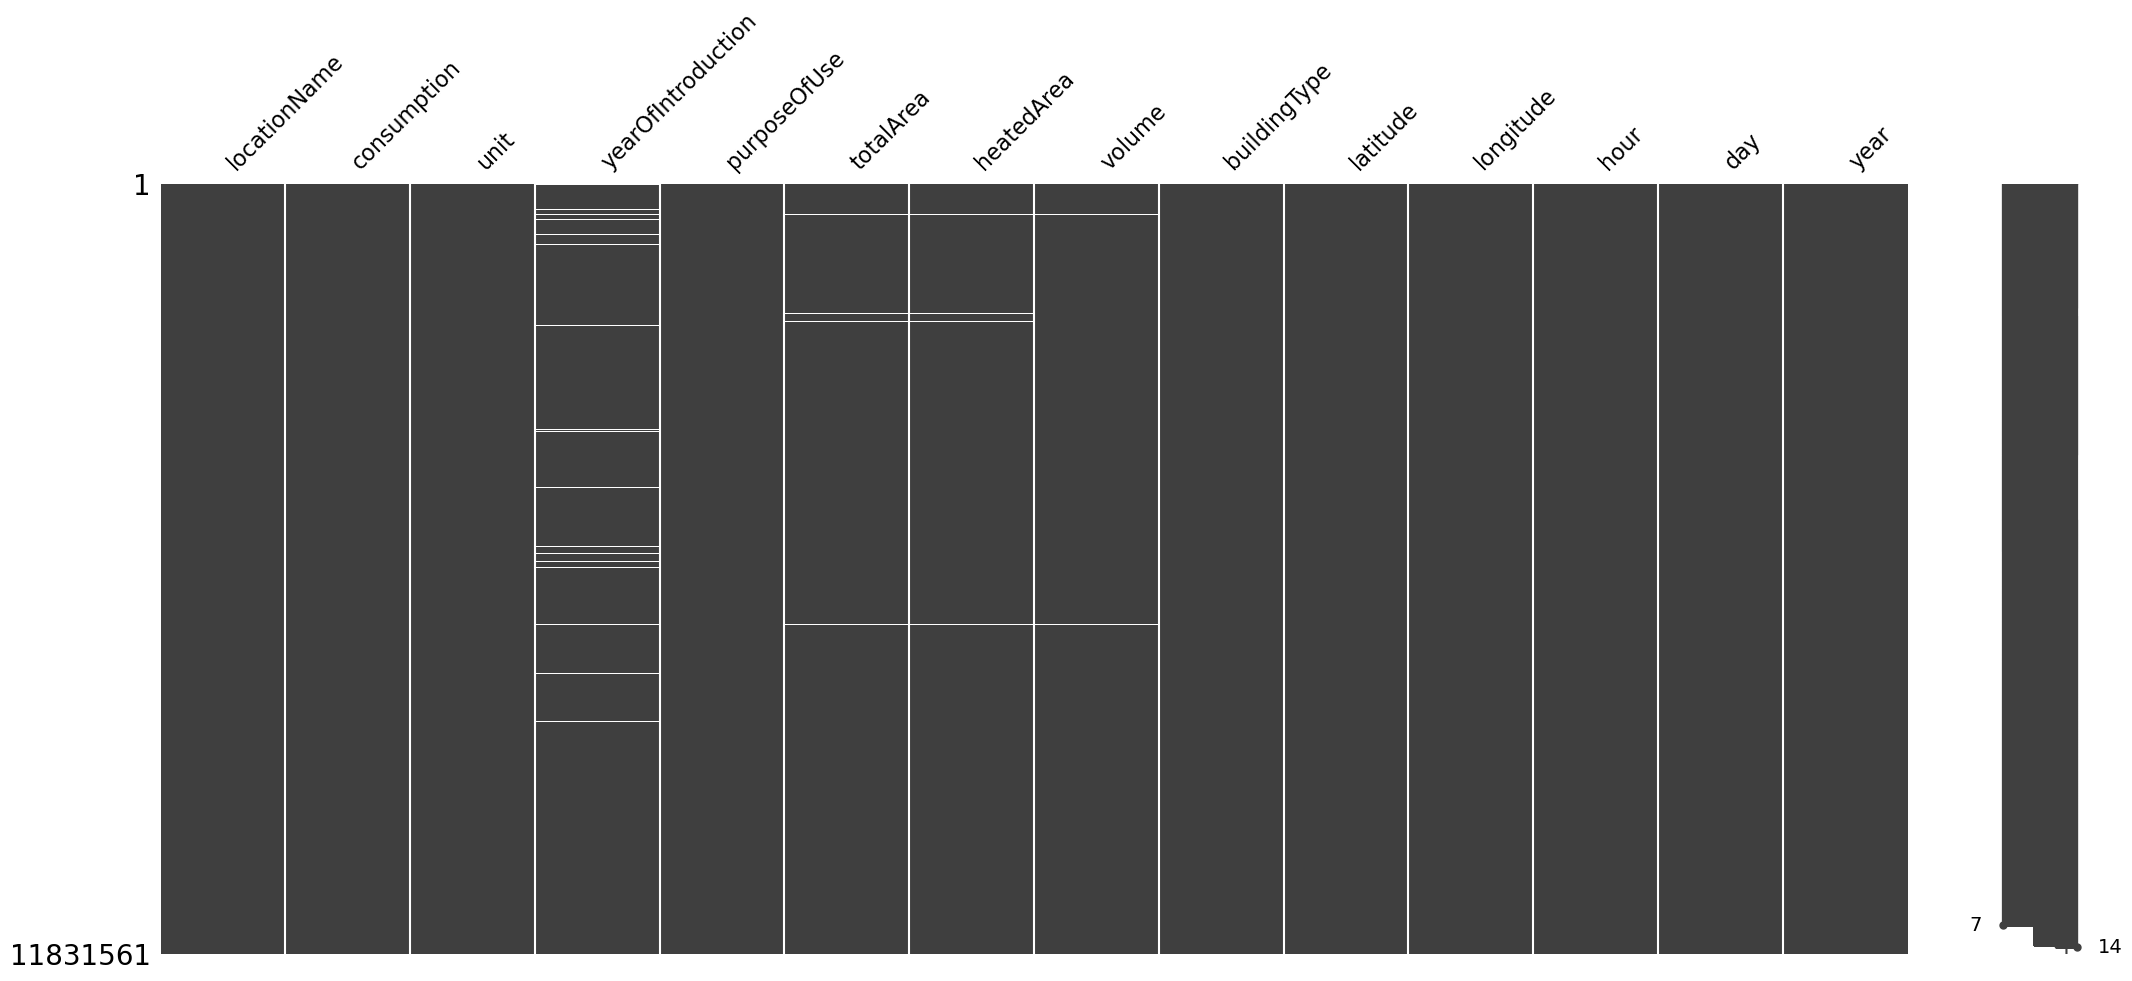

In [23]:
# Visualizing missing values 
msno.matrix(df)

In [24]:
# Print null values of each column
missing_values = pd.concat([df.isnull().sum(), (df.isnull().sum() / len(df) * 100)], axis=1, keys=['Missing Values', '% Missing']).sort_values(by='Missing Values', ascending=False)
print(missing_values)

                    Missing Values  % Missing
yearOfIntroduction          470200   3.974116
heatedArea                   94418   0.798018
totalArea                    46522   0.393203
volume                       42873   0.362361
purposeOfUse                 24279   0.205205
latitude                     15428   0.130397
longitude                    15428   0.130397
locationName                     0   0.000000
consumption                      0   0.000000
unit                             0   0.000000
buildingType                     0   0.000000
hour                             0   0.000000
day                              0   0.000000
year                             0   0.000000


In [25]:
# Description of numeric cols of df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consumption,11831561.0,113.678630,1393.464330,-1364.08,5.02,13.38,34.66,1086358.625
totalArea,11785039.0,3969.122831,6440.491771,0.00,630.00,1400.00,4942.00,46708.000
heatedArea,11737143.0,3381.536412,5189.047085,0.00,554.00,1175.00,4399.00,41947.600
volume,11788688.0,16574.324512,30594.328282,0.00,1396.00,4970.00,18469.00,209300.000
hour,11831561.0,11.503445,6.922505,0.00,6.00,12.00,18.00,23.000
year,11831561.0,2022.459088,0.498323,2022.00,2022.00,2022.00,2023.00,2023.000


In [26]:
# Unique values of each column
unique_counts = df.nunique()

# Display the counts
print(unique_counts)

locationName             643
consumption           179993
unit                       1
yearOfIntroduction       112
purposeOfUse              33
totalArea                575
heatedArea               567
volume                   546
buildingType              31
latitude                 627
longitude                627
hour                      24
day                        7
year                       2
dtype: int64


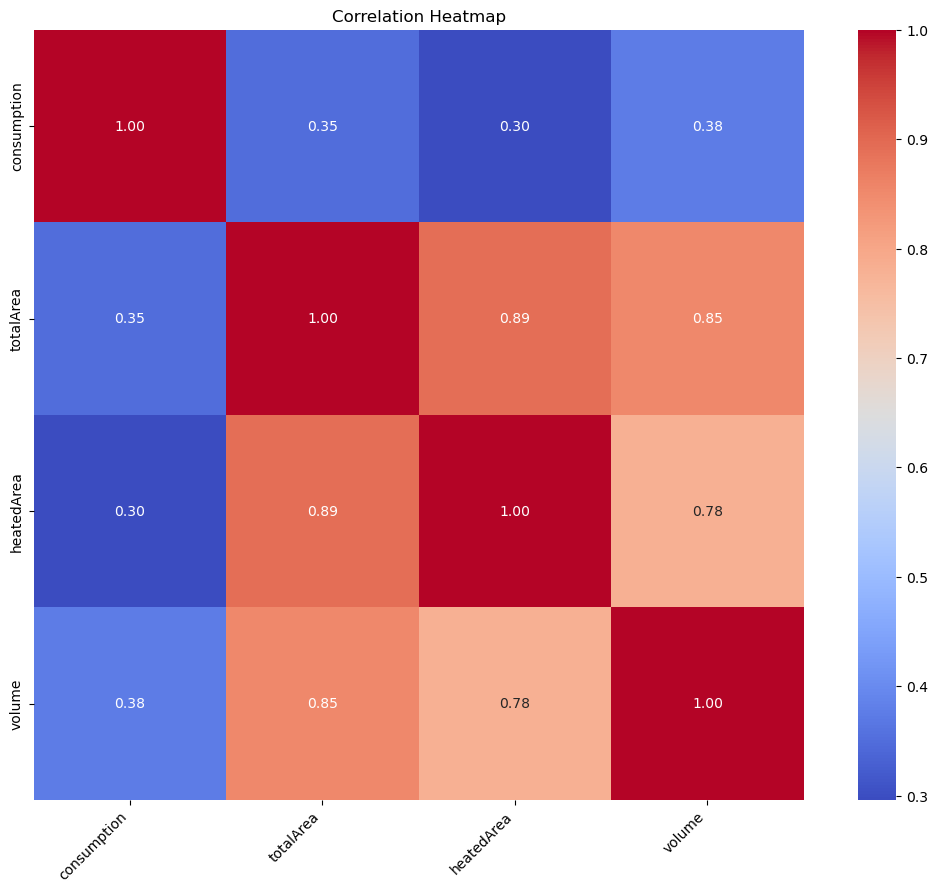

In [27]:
# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
heatmap_check = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap="coolwarm", square=True)
heatmap_check.set_title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.show()

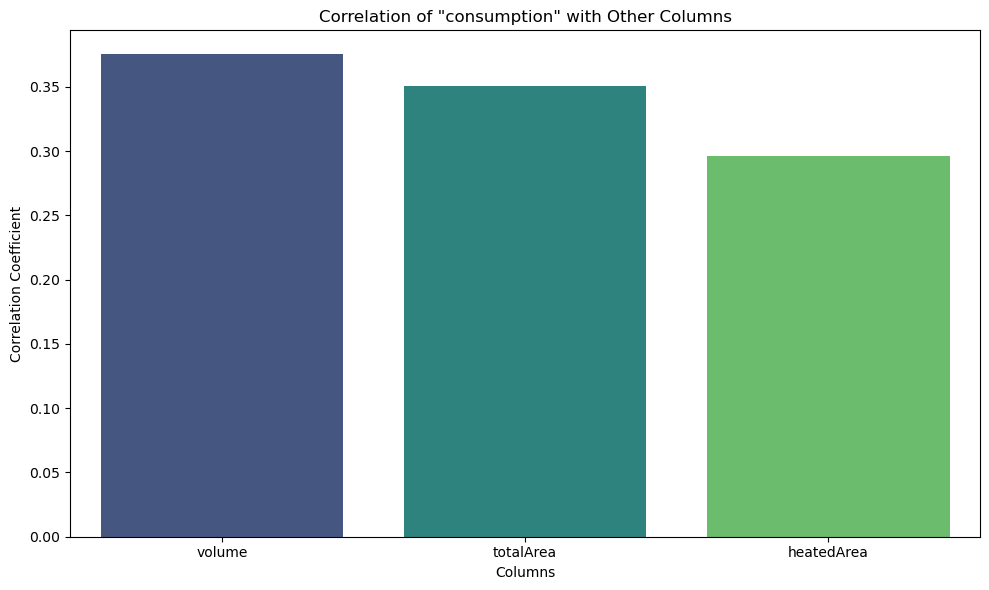

In [28]:
# Setting "consumption" as target
target_column = "consumption"

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlations of "consumption" with all other numeric columns
correlations = df[numeric_columns].corr()[target_column].sort_values(ascending=False)

# Exclude the target column from the correlations
correlations = correlations.drop(target_column, errors='ignore')

# Plot the correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette="viridis")
plt.title(f'Correlation of "{target_column}" with Other Columns')
plt.xlabel("Columns")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

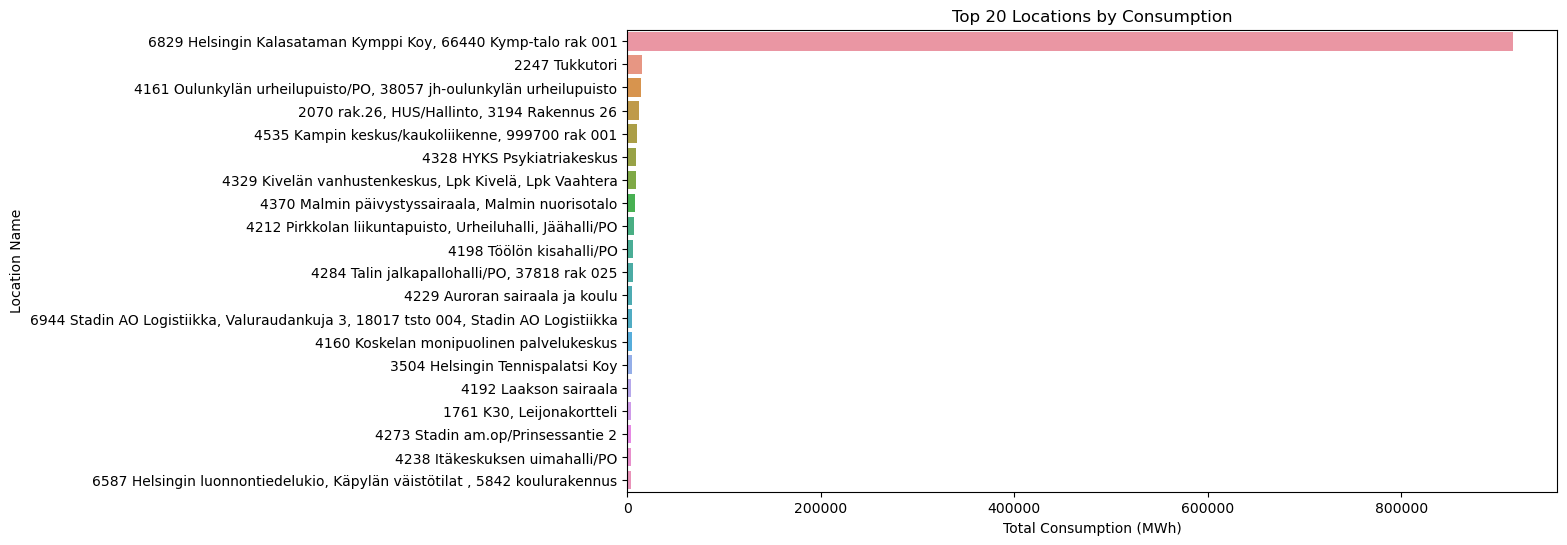

In [29]:
# Top 20 locations by consumption
top_locations = df.groupby('locationName')['consumption'].sum().nlargest(20) / 1000  # Convert from KWh to MWh

plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.xlabel('Total Consumption (MWh)') 
plt.ylabel('Location Name')
plt.title('Top 20 Locations by Consumption')
plt.show()

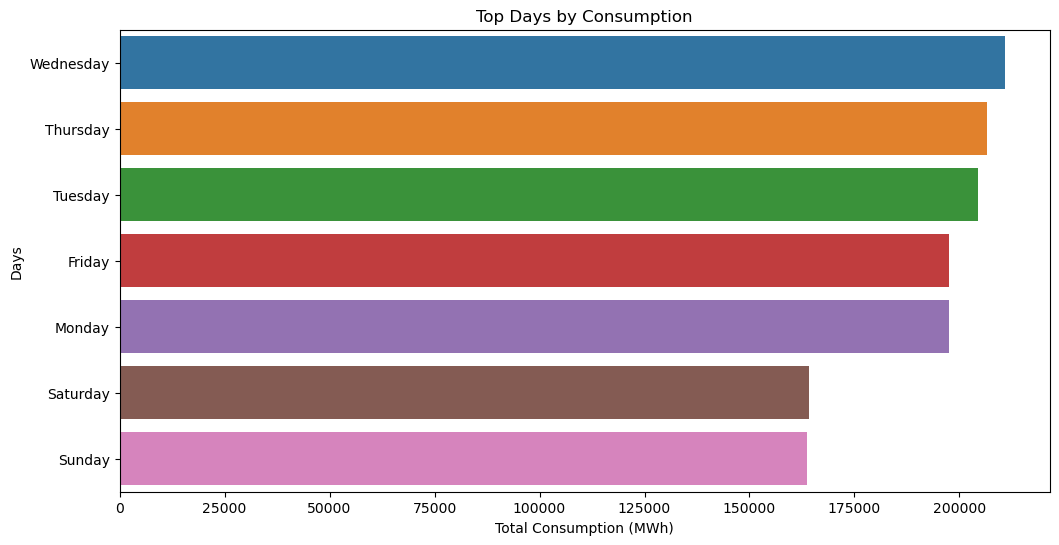

In [30]:
# Top 20 days by consumption
top_days = df.groupby('day')['consumption'].sum().nlargest(20) / 1000 # Convert from KWh to MWh

plt.figure(figsize=(12, 6))
sns.barplot(x=top_days.values, y=top_days.index)
plt.xlabel('Total Consumption (MWh)') 
plt.ylabel('Days')
plt.title('Top Days by Consumption')
plt.show()

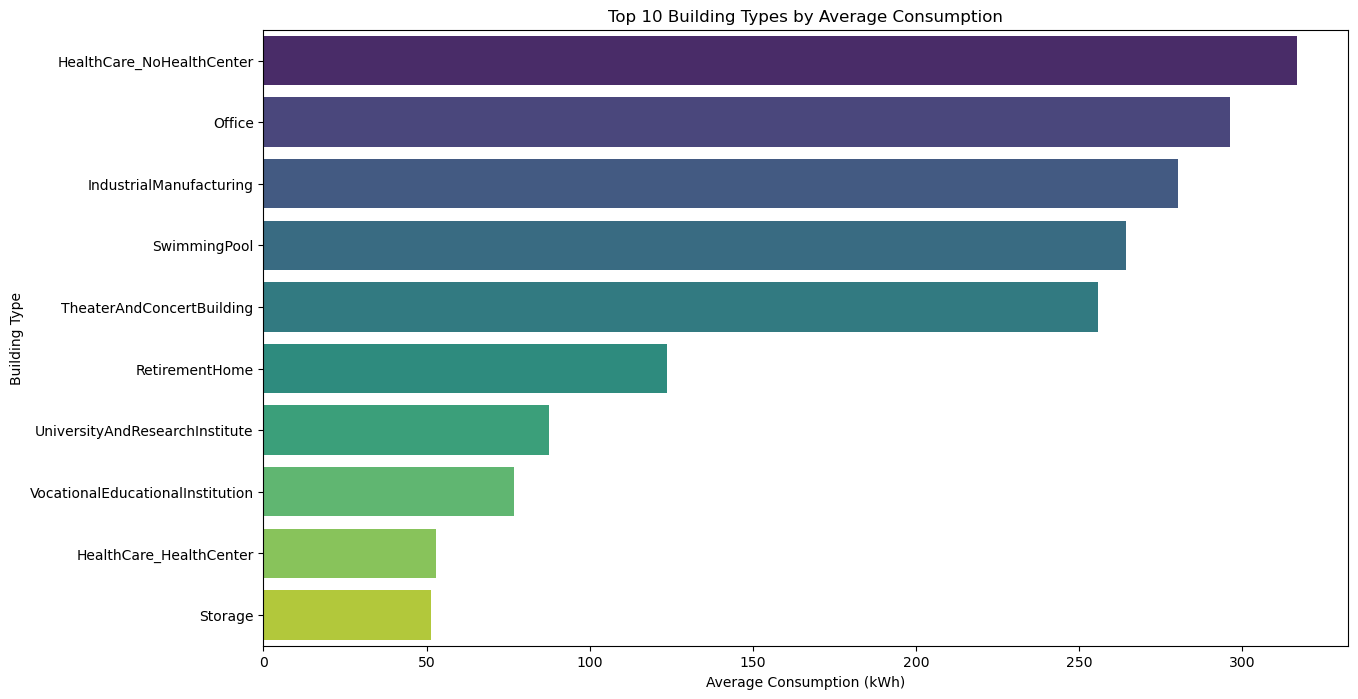

In [31]:
top_n = 10 

# Calculate average consumption for each building type
top_building_types = df.groupby('buildingType')['consumption'].mean().nlargest(top_n)

# Plot the top N building types
plt.figure(figsize=(14, 8))
sns.barplot(x=top_building_types.values, y=top_building_types.index, palette='viridis')
plt.xlabel('Average Consumption (kWh)')
plt.ylabel('Building Type')
plt.title(f'Top {top_n} Building Types by Average Consumption')
plt.show()

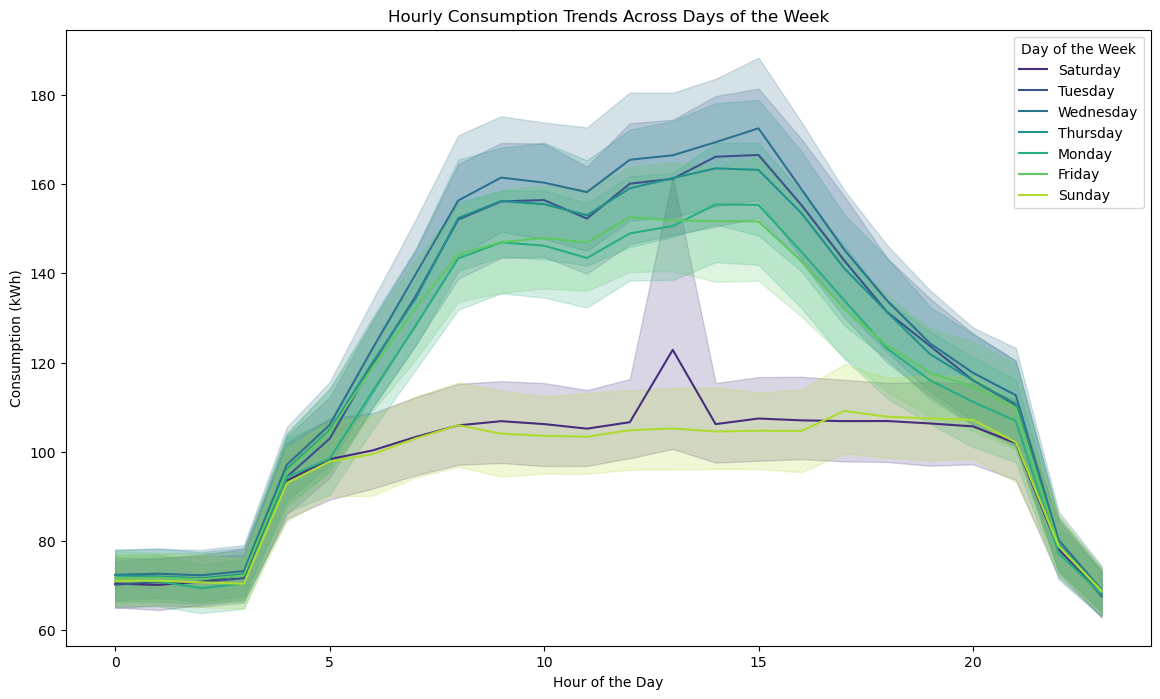

In [32]:
plt.figure(figsize=(14, 8))
sns.lineplot(x='hour', y='consumption', hue='day', data=df, palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption (kWh)')
plt.title('Hourly Consumption Trends Across Days of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1, 1))
plt.show()

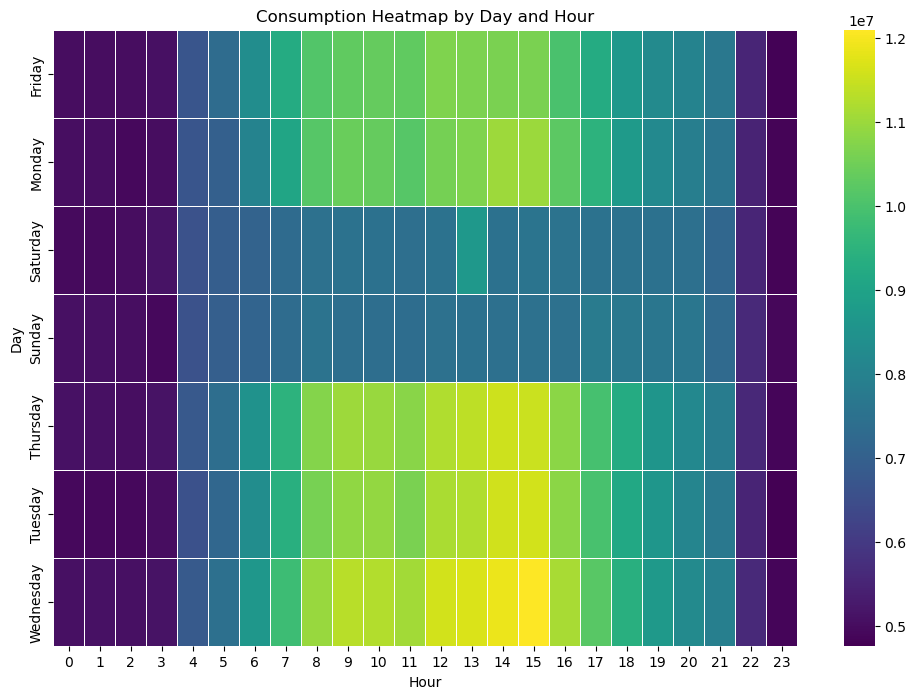

In [33]:
pivot_df = df.pivot_table(index='day', columns='hour', values='consumption', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', linewidths=.5)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Consumption Heatmap by Day and Hour')
plt.show()

In [34]:
# H0: There is no significant difference in consumption between weekdays and weekends.
# H1: There is a significant difference in consumption between weekdays and weekends.

# Create a new column to categorize weekdays and weekends
df['weekday_category'] = np.where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday', 'weekend')

# Extract consumption data for weekdays and weekends
consumption_weekday = df.loc[df['weekday_category'] == 'weekday', 'consumption']
consumption_weekend = df.loc[df['weekday_category'] == 'weekend', 'consumption']

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(consumption_weekday, consumption_weekend, equal_var=False)

print(f'T-Statistic: {t_stat}\nP-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in consumption between weekdays and weekends.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in consumption between weekdays and weekends.")

T-Statistic: 28.376819300407494
P-value: 4.00016370615635e-177
Reject the null hypothesis.
There is a significant difference in consumption between weekdays and weekends.


In [35]:
# H0: There is no significant difference in consumption among different building types.
# H1: There is a significant difference in consumption among different building types.

# Extract consumption data for each building type
building_types = df['buildingType'].unique()

# Create a dictionary to store consumption data for each building type
consumption_data_by_building = {building: df.loc[df['buildingType'] == building, 'consumption'] for building in building_types}

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*consumption_data_by_building.values())

print(f'F-Statistic: {f_stat}\nP-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in consumption among different building types.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in consumption among different building types.")

F-Statistic: 3270.415189396185
P-value: 0.0
Reject the null hypothesis.
There is a significant difference in consumption among different building types.
